In [8]:
#default_exp estimators

In [9]:
#hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2 #autoreload to make code from other modules get updated online inside notebook

import sys
sys.path.append('..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root

#DO NOT EDIT

# Code

In [10]:
#export
import multiprocessing
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
from dask import delayed, compute

from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

from fkausality.kernel import JaccardForestKernel
from fkausality.utils import hstack, vstack
from fkausality.dist import sample_from_neighbors_continuous, estimate_mean_and_variance_from_neighbors_mixture

## Helping functions and classes

In [11]:
#from sklearn.linear_model import LinearRegression
#s = df_obs.sample(100)
#%timeit LinearRegression().fit(s[Tc],s[yc])
#%timeit np.cov(s[Tc],s[yc], rowvar = False, aweights = np.random.random(100))
#%timeit sm.OLS(s[yc],s[Tc]).fit()


In [12]:
#export 

def pandas_gorupby_apply_parallel(dfGrouped, func, **kwargs):
    with Pool(cpu_count()) as p:
        ret_list = p.map(partial(func, **kwargs), [group for name, group in dfGrouped])
    return ret_list

def idxs_split(a, n, axis = 0, drop_empty = True, return_slices = False):
    '''
    returns indices of the n splits of the a array along axis
    '''
    if not hasattr(a, 'shape'):
        a = np.arange(len(a))
    idxs = np.array_split(np.arange(a.shape[axis]), n, axis = 0)
    idxs = [list(i) for i in idxs]
    
    if drop_empty:
        idxs = [i for i in idxs if i]
    
    if return_slices:
        idxs = [slice(min(i), max(i)+1) for i in idxs if i]
        
    return idxs

def _agg_covariance(df, y_columns, T_columns, alpha):
    '''
    covariance of a given target sample in relation to some given Treatment
    '''
    
    import statsmodels.api as sm
    w = (1 - df['dissimilarity'])**alpha
    model = sm.WLS(df[y_columns],df[T_columns],w).fit()
    
    std = model.bse
    #std.columns = ['std' for _ in std.columns]
    slope = model.params
    #slope.columns = ['slope' for _ in slope.columns]
    count = (slope*0+1)*df.shape[0]
    pvalues = model.pvalues
    

    d = [slope,std,count, pvalues]

    idx = pd.Index(['slope','std','count','p_value'], name = 'statistic')
    d = pd.DataFrame(d, index = idx)            

        
    return d

def _agg_mean_variance(df, y_columns, alpha, variance_mapper, min_var_factor):
    '''
    calculates mean and variance for a given sample in groupby
    '''
    mean, var = estimate_mean_and_variance_from_neighbors_mixture(
        df[y_columns].values,
        df['dissimilarity'].values,
        alpha = alpha,
        variance_mapper = variance_mapper,
        min_var_factor = min_var_factor,
    )
        
    count = df.shape[0]
    if var.ndim > 1:        
        
        std = std.diagonal()**(1/2)
        d = np.concatenate([mean,var,count*np.ones(mean.shape)]).reshape(3,len(y_columns))
    else:
        d = [mean,std,count]
    
    d = pd.DataFrame(d)
    
    
    d.index = pd.Index(['mean','std','count'], name = 'statistic')
    d.columns = y_columns    
        
    return d

In [13]:
#export
class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ 
    A sklearn-style wrapper for formula-based statsmodels regressors,
    thanks to https://nelsonauner.com/data/2018/05/21/wrap-statsmodels-in-sklearn.html
    """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)
    
class SMWrapper(BaseEstimator, RegressorMixin):
    """ 
    A universal sklearn-style wrapper for statsmodels regressors ,
    thanks to https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible/
    """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

## Base class _FKEstimator

In [14]:
#export
class _FKEstimator(BaseEstimator):
    
    def __init__(
        self,
        tree_ensemble_estimator,
        #pointwise variance args
        pointwise_variance_dist = 'normal',
        pointwise_variance_alpha = 1,
        pointwise_variance_min_var = 1e-2,
        #knn index args
        n_neighbors=30,
        index_time_params={'M': 30, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0},
        query_time_params={'efSearch': 100},     
        n_jobs = None
        
    ):
        
        #tree estimator
        self.tree_ensemble_estimator = tree_ensemble_estimator
        #pointiwse variance for sampling
        self.pointwise_variance_dist = pointwise_variance_dist
        self.pointwise_variance_alpha = pointwise_variance_alpha
        self.pointwise_variance_min_var = pointwise_variance_min_var
        #knn indexing
        self.n_neighbors = n_neighbors
        self.index_time_params = index_time_params
        self.query_time_params = query_time_params
        self.n_jobs = n_jobs
        return
        
    def fit(self, X, y = None, T = None, save_values = None, **kwargs):        
        
        #fit matching forest estimator
        self.forest_estimator_kernel = JaccardForestKernel(
            estimator=self.tree_ensemble_estimator,
            n_neighbors=self.n_neighbors,
            index_time_params=self.index_time_params,
            query_time_params=self.query_time_params,
        )
                                
        #handle save values
        if not save_values is None:
            if not hasattr(save_values, 'columns'):
                if save_values.ndim == 1:
                    save_values = save_values.reshape(-1,1)                
                else:
                    pass
                save_values_columns_ = [f'saved_value_{i}' for i in range(y.shape[-1])]
            else:
                save_values_columns_ = list(save_values.columns)
        else:
            self.save_values_columns_ = []
            save_values = np.empty((y.shape[0], 0), )
                    
        #handle y saving
        if not hasattr(y, 'columns'):
            if y.ndim == 1:
                y = y.reshape(-1,1)        
            else:
                pass
            y_columns_ = [f'target_{i}' for i in range(y.shape[-1])]
        else:
            y_columns_ = list(y.columns)
        
        #handle T saving
        if not hasattr(T, 'columns'):
            if T.ndim == 1:
                T = T.reshape(-1,1)        
            else:
                pass
            T_columns_ = [f'treatment_{i}' for i in range(y.shape[-1])]
        else:
            T_columns_ = list(T.columns)
        
        #cast to array
        save_values = np.array(save_values)
        y = np.array(y)
        T = np.array(T)
        #remove from save_values cols that are already in y or T
        all_save_columns = pd.Series(save_values_columns_ + T_columns_ + y_columns_)
        keep_cols_msk = (~all_save_columns.duplicated()).values
        all_save_columns = all_save_columns[keep_cols_msk].values.tolist()
        #hstack save_values to y and T
        save_values = hstack([save_values, T, y])[:, keep_cols_msk]
        
        self.forest_estimator_kernel.fit(X, y = T, save_values = save_values, **kwargs) #matching esstimator regress X on T
        
        self.saved_values_ = save_values
        self.save_values_columns_ = save_values_columns_
        self.T_columns_ = T_columns_
        self.y_columns_ = y_columns_
        self.all_saved_values_columns_ = all_save_columns
        return self
    
    #def _saved_data_to_pandas(self, values):
        #list is returned from query, so we have to iterate                
    #    return [pd.DataFrame(v, columns = self.all_saved_values_columns_) for v in values]
    
    def kneighbors(self, X = None, n_neighbors = None, return_distance = False, query_from = None):
        if not query_from is None:
            params = self.forest_estimator_kernel.nearest_neighbors_estimator.get_params()
            klass = self.forest_estimator_kernel.nearest_neighbors_estimator.__class__
            knn_estim = klass(**params).fit(X)
        else:
            knn_estim = self.forest_estimator_kernel        
            
        return knn_estim.kneighbors(X = X, n_neighbors = n_neighbors, return_distance = return_distance)
    
    def query(self, X = None, n_neighbors = None, precomputed_neighbors = None):
        '''
        queries similar datapoints and returns saved_data from queried indexes, alongside
        jaccard dissimilarity
        '''
        if (hasattr(X, 'index') and hasattr(X, 'columns')): #is a dataframe like
            original_X_idxs = X.index
        else:
            original_X_idxs = np.arange(len(X))
            
        if precomputed_neighbors is None:
            precomputed_neighbors = self.kneighbors(X = X, n_neighbors = n_neighbors, return_distance=True)
                        
        dsts, nbrs_idxs = precomputed_neighbors
                        
        values = []
        for i in range(len(nbrs_idxs)):
            msk_i = dsts[i] < 1 #only examples with dissimilarity < 1
            idx_i = nbrs_idxs[i][msk_i]
            dist_i = dsts[i][msk_i].reshape(-1,1)            
            v = self.saved_values_[idx_i]
            v = np.hstack([v, dist_i, original_X_idxs[i]*np.ones((len(v),1), dtype = int)])
            #faster than using .assign
            v = pd.DataFrame(v, columns = self.all_saved_values_columns_ +['dissimilarity', '_index'])
            v['_index'] = v['_index'].astype(int)
            values.append(v)                        
        
        return values    
    



## High Level Estimators

### Continuous Effect-Discrete Treatment (CEDTEstimator)

In [15]:
#export
class CEDTEstimator(_FKEstimator):
    '''
    Continuous Effect - Discrete Treatmet estimator
    '''            
    def sample(
        self,
        X = None,
        n_neighbors = None,
        precomputed_neighbors = None,
        sample_size = 100,
        alpha = 1,
        noise_type = 'normal',
        variance_mapper='log',
        min_var_factor=0.01,
    ):
        '''
        samples target (y) according to pointwise_variance sampling strategy.
        if not stratify, samples are drawn randomly from neighbors
        '''
        
        queries = self.query(X, n_neighbors = n_neighbors, precomputed_neighbors = precomputed_neighbors)        
        sampled_dfs = []
        for q in queries:            
            sampled_df = (
                q.groupby(self.T_columns_)
                .apply(
                    lambda df: np.hstack(
                        [
                            sample_from_neighbors_continuous(
                            neighborhood_values = df[self.y_columns_].values,
                            jac_dists = df['dissimilarity'].values,
                            size = sample_size, 
                            alpha = alpha,
                            noise_type = noise_type,
                            variance_mapper=variance_mapper,
                            min_var_factor=min_var_factor,                      
                            )[0],                            
                            np.arange(sample_size).reshape(-1,1)
                        ]
                    )
                )
            )
                        
            sampled_df = pd.concat(sampled_df.apply(pd.DataFrame).to_dict())
            sampled_df.columns = self.y_columns_ + ['sample_index']
            sampled_df = sampled_df.reset_index(level = -1, drop = True)
            sampled_df.index = sampled_df.index.set_names(tuple(self.T_columns_))            
            sampled_df['sample_index'] = sampled_df['sample_index'].astype(int)
            sampled_df = sampled_df.set_index('sample_index', append = True)
            sampled_dfs.append(sampled_df)
        
        return sampled_dfs
    
    
    def potential_outcomes(
        self,
        X = None,
        n_neighbors = None,
        precomputed_neighbors = None,
        alpha = 1,        
        variance_mapper = 'log',
        min_var_factor = 1e-2,
    ):
        '''
        infers conditional average treatment effect for each datapoint, taking the
        correlation between the target and the treatment in each neighborhood
        '''
        
        q = self.query(X, n_neighbors = n_neighbors, precomputed_neighbors = precomputed_neighbors)        
        q = pd.concat(q)        
        
        q = q.groupby(['_index'] + self.T_columns_).apply(
                            lambda df: _agg_mean_variance(
                                df,
                                y_columns = self.y_columns_,
                                alpha = alpha,
                                variance_mapper = variance_mapper,
                                min_var_factor = min_var_factor,
                            )
                        )
        
        return q
    
    def treatment_effect(
        self,
        X,
        control,
        n_neighbors = None,
        precomputed_neighbors = None,
        alpha = 1,        
        variance_mapper = 'log',
        min_var_factor = 1e-2,
        
    ):
        
        outcomes = self.potential_outcomes(
            X = X,
            n_neighbors = n_neighbors,
            precomputed_neighbors = precomputed_neighbors,
            alpha = alpha,        
            variance_mapper = variance_mapper,
            min_var_factor = min_var_factor,
        )
        
        #control = 0
        if not isinstance(control, (tuple, list, set)):
            control = (control,)
            
        c_idx_mean = slice(None), *control, 'mean'
        t_idx_mean = slice(None), *[slice(None)]*len(control),'mean'
        
        c_idx_var = slice(None), *control, 'variance'
        t_idx_var = slice(None), *[slice(None)]*len(control),'variance'
        
        means = outcomes.loc[t_idx_mean] - outcomes.loc[c_idx_mean]
        var = outcomes.loc[t_idx_var] + outcomes.loc[c_idx_var]

        var['statistic'] = 'variance'
        means['statistic'] = 'mean'

        var = var.set_index('statistic', append = True)
        means = means.set_index('statistic', append = True)
        
        outcomes.loc[var.index] = var
        outcomes.loc[means.index] = means
        return outcomes

#### Usage

In [16]:
#data for evaluation
from fklearn.data.datasets import make_confounded_data
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [17]:
df_rnd, df_obs, df_cf = make_confounded_data(10000)
#calculate treament effect based on counterfactuals
t_effets = (df_obs['recovery'] - df_cf['recovery'])*((-1)**df_cf['medication'])
t_effects_mult = (df_obs['recovery']/df_cf['recovery'])**((-1)**df_cf['medication'])

df_obs['treatment_effect_mult'] = t_effects_mult
df_obs['treatment_effect'] = t_effets
df_obs['cf_recovery'] = df_cf['recovery']

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


medication
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

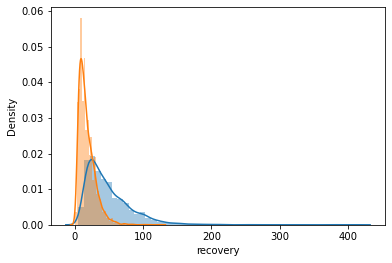

In [18]:
df_rnd.groupby('medication').apply(lambda x: sns.distplot(x['recovery']))

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


medication
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

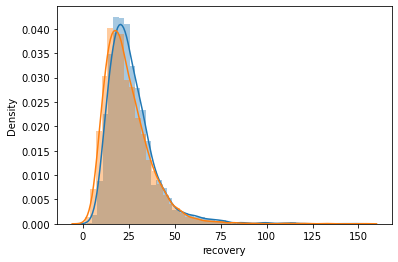

In [19]:
df_obs.groupby('medication').apply(lambda x: sns.distplot(x['recovery']))

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    10000.000000
mean       -30.144300
std         21.483287
min       -289.000000
25%        -40.000000
50%        -25.000000
75%        -15.000000
max          5.000000
Name: treatment_effect, dtype: float64

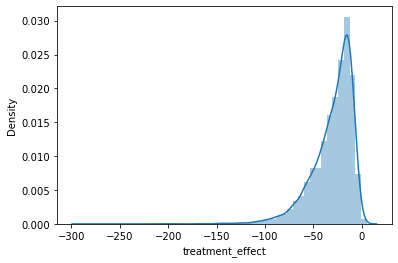

In [20]:
#We can see that the treatment effect can have a negative effect (positive recovery time) in very few cases

sns.distplot(df_obs['treatment_effect'])
df_obs['treatment_effect'].describe()

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.37894582090145834


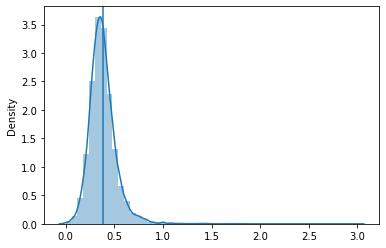

In [14]:
sns.distplot(t_effects_mult)
plt.axvline(t_effects_mult.mean())
print(t_effects_mult.mean())

In [15]:
df_obs['log_treatment_effect'] = -np.log1p(abs(df_obs['treatment_effect']))
df_obs['log_recovery'] = np.log1p(abs(df_obs['recovery']))
df_obs['log_cf_recovery'] = np.log1p(abs(df_obs['cf_recovery']))

In [16]:
Tc = ['medication']
Xc = ['sex','age','severity']
yc = ['recovery']
cf_yc = ['cf_recovery']

X = df_obs[Xc]
T = df_obs[Tc]
y = df_obs[yc]

In [17]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier

tree_estim = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 10, criterion = 'entropy')
estim = CEDTEstimator(tree_estim, n_neighbors = 100, n_jobs = None).fit(X, y = y, T = T, save_values = df_obs)

..\fkausality\kernel.py:537: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y, **kwargs)


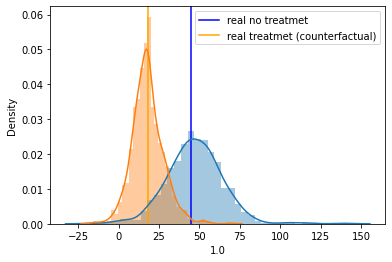

In [683]:
alpha = 1
if not 'i' in locals():
    i = 0
i += 1 
ground_truth = df_obs.iloc[i]
samples = estim.sample(X.iloc[i:i+1],sample_size = 1000, n_neighbors = 1000, noise_type = 'normal', alpha = alpha)[0]
#estim_effect = estim.treatment_effect(X.iloc[i:i+1], n_neighbors = 1000, alpha = alpha, control_name = 0)[0]

got_medication = ground_truth[Tc[0]] == 1

t_recovery = ground_truth[yc[0]] if got_medication else ground_truth[cf_yc[0]]
nt_recovery = ground_truth[yc[0]] if not got_medication else ground_truth[cf_yc[0]]

nt_text = ' (counterfactual)' if got_medication else ''
t_text = ' (counterfactual)' if not got_medication else ''

plt.axvline(nt_recovery, color = 'b', label = f'real no treatmet{t_text}')
plt.axvline(t_recovery, color = 'orange', label = f'real treatmet{nt_text}')


samples.groupby(Tc)[yc[0]].apply(sns.distplot)
plt.legend()



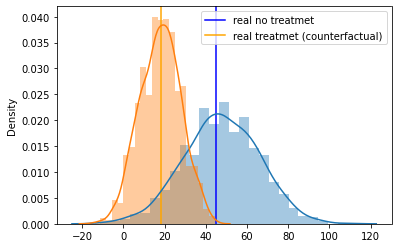

In [684]:
outcomes = estim.potential_outcomes(X.iloc[i:i+10].values, n_neighbors = 1000, alpha = alpha).loc[0]

plt.axvline(nt_recovery, color = 'b', label = f'real no treatmet{t_text}')
plt.axvline(t_recovery, color = 'orange', label = f'real treatmet{nt_text}')

treated_dist = np.random.normal(outcomes.loc[1,'mean'], outcomes.loc[1,'variance']**(1/2), size = 1000)
untreated_dist = np.random.normal(outcomes.loc[0,'mean'], outcomes.loc[0,'variance']**(1/2), size = 1000)

sns.distplot(untreated_dist)
sns.distplot(treated_dist)
plt.legend()

In [685]:
effect_col = 'treatment_effect'
n_estimations = 5_000
alpha = 1
idxs = np.random.choice(len(df_obs), n_estimations, replace = False)
true_effects = df_obs.iloc[idxs][[effect_col, 'treatment_effect_mult']]

In [686]:
query = estim.query(X.iloc[idxs], n_neighbors = 100)
outcomes = estim.potential_outcomes(X.iloc[idxs], n_neighbors = 100, alpha = alpha)
effects = estim.treatment_effect(X.iloc[idxs], n_neighbors = 100, alpha = alpha, control = (0,) )


In [687]:
estimated_effects = effects.query('statistic == "mean" and medication == 1').reset_index(level = ['medication', 'statistic'],drop = True)
estimated_effects_var = effects.query('statistic == "variance" and medication == 1').reset_index(level = ['medication', 'statistic'],drop = True)

In [688]:
true_effects['estimated_treatment_effect'] = estimated_effects
true_effects['estimated_treatment_variance'] = estimated_effects_var
true_effects['estimated_treatment_effect_error'] = true_effects[effect_col] -  true_effects[f'estimated_treatment_effect']
true_effects['eestimated_treatment_effect_mult'] = outcomes.loc[slice(None), 1, 'mean']/outcomes.loc[slice(None), 0, 'mean']

In [689]:
from scipy import stats
from fkausality.dist import PointwiseMixture

def baesyan_bootstrap(samples, n_bootstraped_samples):
    samples = np.array(samples)
    samples = samples[~np.isnan(samples)]
    likelihoods = stats.dirichlet([1]*len(samples)).rvs(n_bootstraped_samples)
    return (likelihoods*samples.reshape(1,-1)).sum(axis = 1)

#mask of valid estimands
msk = (true_effects['estimated_treatment_effect'].notna() & true_effects['estimated_treatment_variance'].notna()).values

mixture = PointwiseMixture().fit(true_effects['estimated_treatment_effect'].values[msk], true_effects['estimated_treatment_variance'].values[msk]**(1/2))
samples_mixture = mixture.sample(10000).flatten()
samples = true_effects['estimated_treatment_effect'][msk]
print(msk.mean())

0.39


In [690]:
q = pd.concat(query).set_index('_index').loc[infvar_indexes].query('medication == 1')

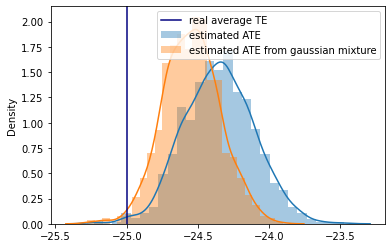

In [691]:
#plot ATE
sns.distplot(baesyan_bootstrap(samples, 1000), label= 'estimated ATE')
sns.distplot(baesyan_bootstrap(samples_mixture, 1000), label= 'estimated ATE from gaussian mixture')
#sns.distplot(true_effects['estimated_treatment_effect'], label= 'estimated ATE')
plt.axvline(true_effects[effect_col][msk].mean(), label = 'real average TE', color = 'navy')

plt.legend()

0.3787112980500153  vs (real) 0.3792387623444339


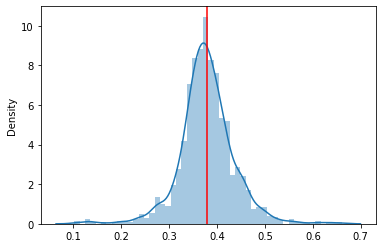

In [692]:
estim_effect_mult = outcomes.loc[slice(None), 1, 'mean']/outcomes.loc[slice(None), 0, 'mean'].dropna()
sns.distplot(estim_effect_mult)
print(estim_effect_mult.dropna().values.flatten().mean(), ' vs (real)', true_effects['treatment_effect_mult'].mean())
#plt.axvline(estim_effect_mult.dropna().values.flatten().mean())
plt.axvline(true_effects['treatment_effect_mult'].mean(), color = 'r')

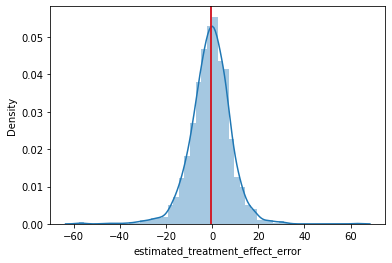

In [693]:
sns.distplot(true_effects['estimated_treatment_effect_error'])
plt.axvline(true_effects['estimated_treatment_effect_error'].mean())
plt.axvline(true_effects['estimated_treatment_effect_error'].median(), color = 'r')

<AxesSubplot:xlabel='estimated_treatment_effect', ylabel='Density'>

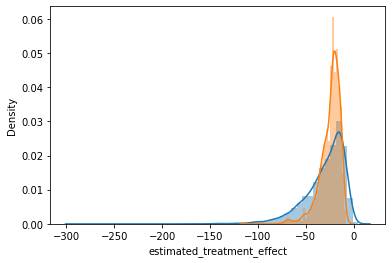

In [694]:
sns.distplot(true_effects['treatment_effect'])
sns.distplot(true_effects['estimated_treatment_effect'])

In [695]:
import warnings
warnings.filterwarnings('ignore')
#time for 1000 queries
%timeit -n 1 -r 1 estim.query(X.iloc[i:i+1000], n_neighbors = 1000)
%timeit -n 1 -r 1 estim.sample(X.iloc[i:i+1000],sample_size = 1000, n_neighbors = 1000, noise_type = 'normal', alpha = alpha)[0]
%timeit -n 1 -r 1 estim.potential_outcomes(X.iloc[i:i+1000], n_neighbors = 1000, alpha = alpha)
%timeit -n 1 -r 1 estim.treatment_effect(X.iloc[i:i+1000], n_neighbors = 1000, alpha = alpha, control = 0)

920 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
9.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [696]:
#TODO: Implement parallel groupby

### Discrete Effect-Continuous Treatment (DECTEstimator)

In [697]:
class DECTEstimator(_FKEstimator):
    '''
    Discrete Effect - Continuous Treatmet estimator
    '''            
    pass

### Discrete Effect-Discrete Treatment (DEDTEstimator)

In [698]:
class DEDTEstimator(_FKEstimator):
    '''
    Discrete Effect - Discrete Treatmet estimator
    '''            
    pass

### Continuous Effect-Continuous Treatment (CECTEstimator)

In [67]:
class CECTEstimator(_FKEstimator):
    '''
    Continuous Effect - Continuous Treatmet estimator
    '''            
    def sample(
        self,
        X = None,
        n_neighbors = None,
        precomputed_neighbors = None,
        sample_size = 100,
        alpha = 1,
        noise_type = 'normal',
        variance_mapper='log',
        min_var_factor=0.01,
    ):
        '''
        samples target (y) according to pointwise_variance sampling strategy.
        if not stratify, samples are drawn randomly from neighbors
        '''
        
        queries = self.query(X, n_neighbors = n_neighbors, precomputed_neighbors = precomputed_neighbors)        
        sampled_dfs = []
        for q in queries:                        
            sampled_values, sampled_idxs = sample_from_neighbors_continuous(                
                neighborhood_values = q[self.y_columns_].values,
                jac_dists = q['dissimilarity'].values,
                size = sample_size, 
                alpha = alpha,
                noise_type = noise_type,
                variance_mapper=variance_mapper,
                min_var_factor=min_var_factor,
            )
            
            
            sampled_df = pd.DataFrame(sampled_values)
            sampled_df.columns = self.y_columns_
            for col in self.T_columns_:
                sampled_df[col] = q[col].values[sampled_idxs]
            
            sampled_df = sampled_df.set_index(self.T_columns_)
            sampled_dfs.append(sampled_df)
        
        return sampled_dfs

    
    def treatment_effect(
        self,
        X = None,
        n_neighbors = None,
        precomputed_neighbors = None,
        alpha = 1,                
    ):
        '''
        infers conditional slope of treatment  for each datapoint, taking the
        linear regression between the target and the treatment in each neighborhood
        '''
        
        q = self.query(X, n_neighbors = n_neighbors, precomputed_neighbors = precomputed_neighbors)        
        q = pd.concat(q)        
        
        
        q = q.groupby(['_index']).apply(
                            lambda df: _agg_covariance(
                                df,
                                y_columns = self.y_columns_,
                                T_columns = self.T_columns_,
                                alpha = alpha,                                
                            )
                        )
        
        return q

### Usage

In [79]:
Tc = ['severity','cf_recovery']
Xc = ['sex','age','medication']
yc = ['recovery']
cf_yc = ['cf_recovery']

X = df_obs[Xc]
T = df_obs[Tc]
y = df_obs[yc]

In [83]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier

tree_estim = RandomForestRegressor(n_estimators = 10, min_samples_leaf = 10,)
estim = CECTEstimator(tree_estim, n_neighbors = 100, n_jobs = None).fit(X, y = y, T = T, save_values = df_obs)

In [85]:
estim.treatment_effect(X.iloc[:100])

severity  cf_recovery
_index statistic                        
0      slope      23.791046    -0.003055
       std         6.525479     0.103695
       count      36.000000    36.000000
       p_value     0.000882     0.976672
1      slope      63.113889     1.955488
...                     ...          ...
98     p_value     0.107672     0.000358
99     slope      25.516479     0.124820
       std        10.914545     0.098109
       count      40.000000    40.000000
       p_value     0.024761     0.211011

[400 rows x 2 columns]

# Export -

In [425]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted dist-checkpoint.ipynb.
Converted estimators-checkpoint.ipynb.
Converted kernel-checkpoint.ipynb.
Converted neighbors-checkpoint.ipynb.
Converted dist.ipynb.
Converted estimators.ipynb.
Converted index.ipynb.
Converted kernel.ipynb.
Converted neighbors.ipynb.
Converted utils.ipynb.
